## **Libraries**

In [ ]:
# Libraries
import os
import zipfile
import shutil
import time
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import metrics

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms

## **Pre-Processing**

### **Unzip**

In [ ]:
# Creating folders for images from 'train' and 'test'
os.makedirs('/content/images', exist_ok = True)
os.makedirs('/content/submission', exist_ok = True)

In [ ]:
# Unziping 'train' images to 'images' folder
with zipfile.ZipFile('/content/drive/MyDrive/AI_CRANFIELD/full_images_jpg/dataset-images-jpg.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/images')

In [ ]:
# Unziping 'test' images to 'submission' folder
with zipfile.ZipFile('/content/drive/MyDrive/AI_CRANFIELD/submission_images_jpg/dataset-submission-images-jpg.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/submission')

### **Dataframes**

In [ ]:
# Import data as dataframe
initial_data = pd.read_csv("/content/drive/MyDrive/AI_CRANFIELD/train.csv")
submission_data = pd.read_csv("/content/drive/MyDrive/AI_CRANFIELD/sample_submission_with_sizes.csv")

In [ ]:
initial_data

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [ ]:
# Function that converts the initial dataframe to a dataframe with only two classes
# INPUT: initial dataframe
# OUTPUT: dataframe with only 2 classes
def convert_to_2_classes(initial_data):

    # Create a dictionnary to save the results
    image_features = {}

    # Go through the initial dataframe
    for i in tqdm(range(len(initial_data))):

        image_id = initial_data.image_id[i]
        class_id = initial_data.class_id[i]

        # Check if we already have seen this image
        if image_id not in image_features.keys():

            # Check if the image don't belong to the class "No Finding"
            if class_id != 14:
                # Update the dictionnary
                image_features[image_id] = [image_id, "Finding", 1]
            else:
                image_features[image_id] = [image_id, "No Finding", 0]
    
    # Convert the dictionnary to a dataframe
    data_2_cls = pd.DataFrame.from_dict(image_features, orient='index', columns=["image_id", "class_name", "class_id"]).sort_values(by="image_id").reset_index(drop=True)
    
    return data_2_cls

In [ ]:
# Apply the function to create a new dataframe
data_2_cls = convert_to_2_classes(initial_data)

  0%|          | 0/67914 [00:00<?, ?it/s]

In [ ]:
# Display this dataframe
data_2_cls

,image_id,class_name,class_id
0,000434271f63a053c4128a0ba6352c7f,No Finding,0
1,00053190460d56c53cc3e57321387478,No Finding,0
2,0005e8e3701dfb1dd93d53e2ff537b6e,Finding,1
3,0006e0a85696f6bb578e84fafa9a5607,No Finding,0
4,0007d316f756b3fa0baea2ff514ce945,Finding,1
...,...,...,...
14995,ffe6f9fe648a7ec29a50feb92d6c15a4,Finding,1
14996,ffea246f04196af602c7dc123e5e48fc,No Finding,0
14997,ffeffc54594debf3716d6fcd2402a99f,Finding,1
14998,fff0f82159f9083f3dd1f8967fc54f6a,No Finding,0


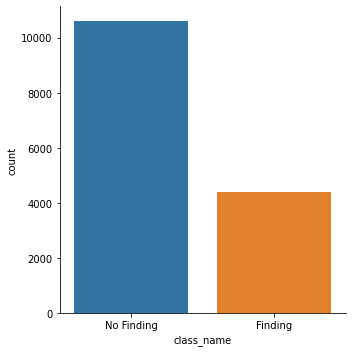

In [ ]:
# Some visualisation for displaying the imbalance data
sns.catplot(data=data_2_cls, x="class_name", kind="count")

In [ ]:
# Function that pre-processes the submission data
# INPUT: submission dataframe
# OUTPUT: submission dataframe pre-processed
def pre_process_submission_data(submission_data):

    # Initialize prediction value to 0
    submission_data['PredictionString'] = 0

    # Initialize class value to 'No Finding'
    submission_data['class_name'] = 'No Finding'

    # Rename column
    submission_data.rename(columns={"PredictionString": "class_id"}, inplace=True)

    # Drop column
    submission_data.drop(["width", "height"], axis=1, inplace=True)

    # Reorder columns
    new_cols = ["image_id","class_name","class_id"]
    submission_data=submission_data[new_cols]

    return submission_data

In [ ]:
# Apply the function to create a new dataframe
submission_data = pre_process_submission_data(submission_data)

# Display this dataframe
submission_data

,image_id,class_name,class_id
0,002a34c58c5b758217ed1f584ccbcfe9,No Finding,0
1,004f33259ee4aef671c2b95d54e4be68,No Finding,0
2,008bdde2af2462e86fd373a445d0f4cd,No Finding,0
3,009bc039326338823ca3aa84381f17f1,No Finding,0
4,00a2145de1886cb9eb88869c85d74080,No Finding,0
...,...,...,...
2995,ff91fb82429a27521bbec8569b041f02,No Finding,0
2996,ff9fcc4087ed5e941209aa3fa948e364,No Finding,0
2997,ffaa288c8abca300974f043b57d81521,No Finding,0
2998,ffc441e0c8b7153844047483a577e7c3,No Finding,0


### **Images**

In [ ]:
# Function that pre-processes correctly the images from a folder and save them into another folder
# INPUT: dataframe, input folder, output folder
# OUTPUT: None
def pre_process_images(data, in_folder, out_folder):

    # Create the output folder
    os.makedirs(out_folder, exist_ok = True)

    # Go through each image of the dataframe
    for id in tqdm(data['image_id'].unique()):

        # Open this image with PIL
        img = Image.open(in_folder + id + ".jpg")

        # Convert to an float array
        img_array = np.array(img)
        img_array = img_array.astype(np.float64)

        # Resize the image to (256,256)
        img_array = cv2.resize(img_array, (256, 256), interpolation=cv2.INTER_CUBIC)

        # Standardize the image
        img_array = img_array - np.min(img_array)
        img_array = img_array / np.max(img_array)
        img_array = (img_array * 255).astype(np.uint8)
        
        # Save this image as .png into the output folder
        cv2.imwrite(out_folder + '{}.png'.format(id), img_array)

In [ ]:
# Apply the function to create a new folder with pre-processed images for training
pre_process_images(data_2_cls, '/content/images/full-dataset-images-jpg/', '/content/images-256/')

  0%|          | 0/15000 [00:00<?, ?it/s]

In [ ]:
# Apply the function to create a new folder with pre-processed images for submission
pre_process_images(submission_data, '/content/submission/', '/content/submission-256/')

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
# Save the path of the new folders into the corresponding dataframe
data_2_cls['image_path'] = '/content/images-256/' + data_2_cls['image_id'] + '.png'
submission_data['image_path'] = '/content/submission-256/' + submission_data['image_id'] + '.png'

<ipython-input-15-301ce7c2d8bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_data['image_path'] = '/content/submission-256/' + submission_data['image_id'] + '.png'


### **Pre-Process Training**

In [ ]:
# Function that creates a dataframe for training and validation and folders with respectives images
# INPUT: dataframe
# OUTPUT: training dataframe, validation dataframe
def set_up_training(data_2_cls):

    # Ratio for validation set
    test_size = 0.2 

    # Divide data between training and validation using the argument 'stratify' for imbalanced data
    data_train, data_val = train_test_split(data_2_cls, test_size=test_size, random_state=123, stratify=data_2_cls['class_id'])

    # Reset index of those dataframe
    data_train.reset_index(drop=True, inplace=True)
    data_val.reset_index(drop=True, inplace=True)

    # Create folder to store the corresponding images for training and validation
    os.makedirs('/content/vinbigdata/images/train', exist_ok = True)
    os.makedirs('/content/vinbigdata/images/val', exist_ok = True)

    # Go through the training dataframe
    for file in tqdm(data_train.image_path):
        # Copy the image to a 'train' folder
        shutil.copy(file, '/content/vinbigdata/images/train')
        filename = file.split('/')[-1].split('.')[0]
    
    # Go through the validation dataframe
    for file in tqdm(data_val.image_path):
        # Copy the image to a 'val' folder
        shutil.copy(file, '/content/vinbigdata/images/val')
        filename = file.split('/')[-1].split('.')[0]
    
    return data_train, data_val

In [ ]:
# Apply the function to create 2 dataframes and images folders (training and validation)
data_train, data_val = set_up_training(data_2_cls)

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
# Display the resulting dataframe
data_train

,image_id,class_name,class_id,image_path
0,5480af204701170956ce3d98f363a3c2,Finding,1,/content/images-256/5480af204701170956ce3d98f3...
1,8900e436ef9c73811c793b32127de1b8,Finding,1,/content/images-256/8900e436ef9c73811c793b3212...
2,10c4ce27df80f3551ec62c7bf2272008,No Finding,0,/content/images-256/10c4ce27df80f3551ec62c7bf2...
3,8fc79a203e64c849cd6b176be004534d,No Finding,0,/content/images-256/8fc79a203e64c849cd6b176be0...
4,e33f67bb274e75146faa95baaa6fbd47,No Finding,0,/content/images-256/e33f67bb274e75146faa95baaa...
...,...,...,...,...
11995,9802dac0c641057a92a761cb932324e2,No Finding,0,/content/images-256/9802dac0c641057a92a761cb93...
11996,8e5f9d775ab631aca970ca98d32946dc,Finding,1,/content/images-256/8e5f9d775ab631aca970ca98d3...
11997,3b9c1ab510d5d088a5668af119552350,No Finding,0,/content/images-256/3b9c1ab510d5d088a5668af119...
11998,6e11ca52ad7ea9add47da7eded8efe03,Finding,1,/content/images-256/6e11ca52ad7ea9add47da7eded...


### **Datasets / Dataloaders**

In [ ]:
# Class that creates a dataset from a dataframe
# INPUT: dataframe, torch transformation
# OUPUT: torch dataset
class CustomDataset(data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __getitem__(self, index):
        # Recover the image path
        image_path = self.dataframe.iloc[index, 3]

        # Open the image with PIL
        image = Image.open(image_path).convert('RGB')

        # Recover the corresponding label
        label = self.dataframe.iloc[index, 2]
        
        # Transform the image
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.dataframe)

In [ ]:
# Function that creates torch dataset for training, validation and submission
# INPUT: training, validation and submission dataframes
# OUPUT: training, validation and submission PyTorch datasets
def create_datasets(data_train, data_val, submission_data):

    # Define the transforms for the dataset
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Create an instance of the custom dataset for training, validation and submission
    train_dataset = CustomDataset(data_train, transform)
    val_dataset = CustomDataset(data_val, transform)
    submission_dataset = CustomDataset(submission_data, transform)

    return train_dataset, val_dataset, submission_dataset

In [ ]:
# Apply the function to create 3 PyTorch datasets
train_dataset, val_dataset, submission_dataset = create_datasets(data_train, data_val, submission_data)

In [ ]:
# Function that creates torch dataloaders for training, validation and submission
# INPUT: training dataframe, training/validation/submission PyTorch datasets
# OUPUT: training, validation and submission PyTorch dataloaders
def create_dataloaders(data_train, train_dataset, val_dataset, submission_dataset):

    # Calculate weights for each class
    class_labels = data_train['class_id'].unique()
    class_weights = compute_class_weight(
                                            class_weight = "balanced",
                                            classes = np.unique(class_labels),
                                            y = data_train['class_id']                                                   
                                        )
    class_weights = torch.FloatTensor(class_weights)

    # Create a WeightedRandomSampler for training dataloader
    train_sampler = data.WeightedRandomSampler(class_weights[data_train['class_id'].values], len(data_train))

    # Define PyTorch dataloaders for training, validation and submission
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, num_workers=2, sampler=train_sampler, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
    submission_loader = torch.utils.data.DataLoader(submission_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)

    return train_loader, val_loader, submission_loader

In [ ]:
# Apply the function to create 3 PyTorch dataloaders
train_loader, val_loader, submission_loader = create_dataloaders(data_train, train_dataset, val_dataset, submission_dataset)

In [ ]:
# Store the datasets and dataloaders into dictionnaries
image_datasets = {'train': train_dataset, 'val': val_dataset}
dataloaders = {'train': train_loader, 'val': val_loader}

# Store the length of each dataframe (training and validation) in a dictionnary
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Store 'class_id' and 'class_name' in a dictionnary
class_names = {0: "No Finding", 1: "Finding"}

# Initialise the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

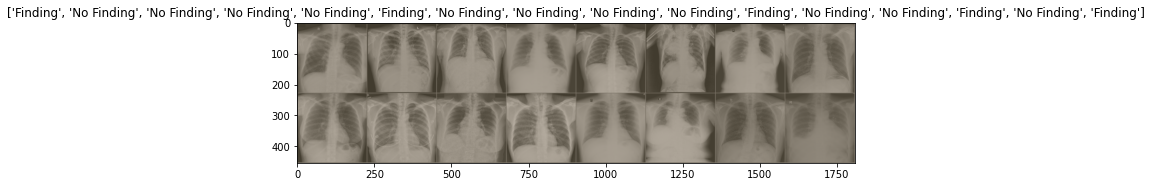

In [ ]:
# Function that displays a batch with its labels
# INPUT: grid of that PyTorch batch
# OUPUT: None
def imshow(inp, title=None):
    
    # Pre-process the grid from the batch
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # Display it
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Apply the previous fonction on a training batch
imshow(out, title=[class_names[x.item()] for x in classes])

## **Training**

In [ ]:
# Function coming from PyTorch documentation to train a model
# INPUT:  torch model, criterion, optimizer, scheduler, num_epochs
# OUPUT: model trained
def train_model(model, criterion, optimizer, scheduler, num_epochs):

    # Start the timer
    since = time.time()

    # Initialise our best_model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Go trhough epochs
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode
                model.train()  
            else:
                # Set model to evaluate mode
                model.eval()   

            # Initialise loss
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Go forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward and optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Calculate loss
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            # Final loss and accuracy calculated and displayed
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy of the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Runtime of the training
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # Best accuracy reached
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model

### **Model**

In [ ]:
# Recover pre-trained version of ResNet18
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

# Copy model weights on GPU
model_ft = model_ft.to(device)

# Define criterion for loss calculation
criterion = nn.CrossEntropyLoss()

# Define optimizer to observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2725 Acc: 0.8833
val Loss: 0.3182 Acc: 0.8823

Epoch 1/9
----------
train Loss: 0.1709 Acc: 0.9358
val Loss: 0.2146 Acc: 0.9197

Epoch 2/9
----------
train Loss: 0.1221 Acc: 0.9548
val Loss: 0.2079 Acc: 0.9287

Epoch 3/9
----------
train Loss: 0.0937 Acc: 0.9664
val Loss: 0.2227 Acc: 0.9300

Epoch 4/9
----------
train Loss: 0.0783 Acc: 0.9732
val Loss: 0.3049 Acc: 0.9187

Epoch 5/9
----------
train Loss: 0.0623 Acc: 0.9780
val Loss: 0.2690 Acc: 0.9260

Epoch 6/9
----------
train Loss: 0.0516 Acc: 0.9815
val Loss: 0.2456 Acc: 0.9257

Epoch 7/9
----------
train Loss: 0.0226 Acc: 0.9928
val Loss: 0.2230 Acc: 0.9307

Epoch 8/9
----------
train Loss: 0.0162 Acc: 0.9959
val Loss: 0.2309 Acc: 0.9297

Epoch 9/9
----------
train Loss: 0.0159 Acc: 0.9947
val Loss: 0.2396 Acc: 0.9320

Training complete in 12m 48s
Best val Acc: 0.932000


### **Visualisation**

In [ ]:
# Function that display images from validation batches with their prediction and real classes
# INPUT: trained model, number of images from the batch
# OUPUT: None
def visualize_model(model, num_images=6):

    # Model state
    was_training = model.training
    model.eval()

    # Counter for images
    images_so_far = 0

    # Go through the validation dataloader
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Recover the prediction
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Display each image of the batch with their prediction and label
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}, truth: {class_names[labels[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

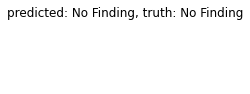

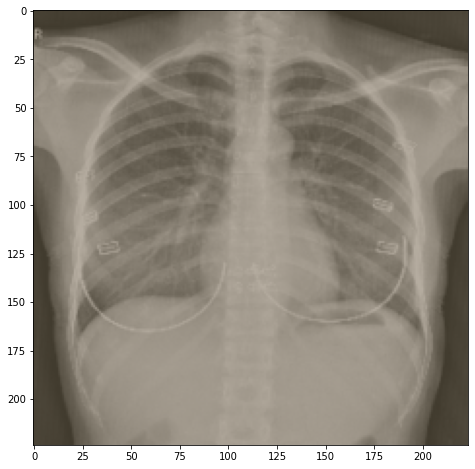

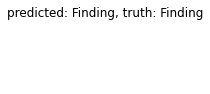

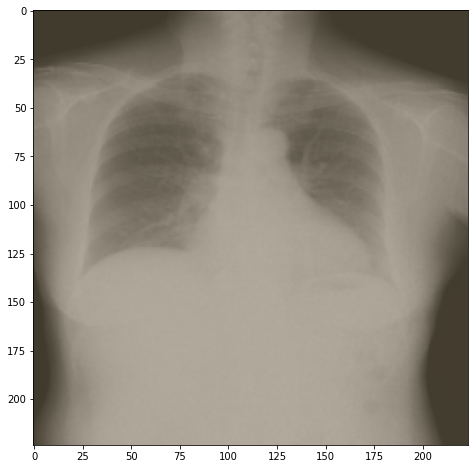

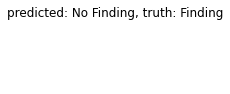

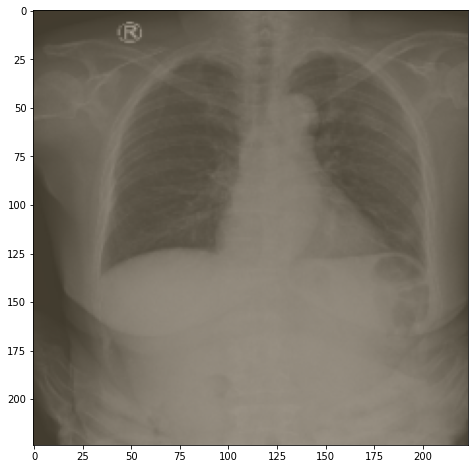

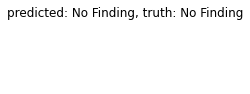

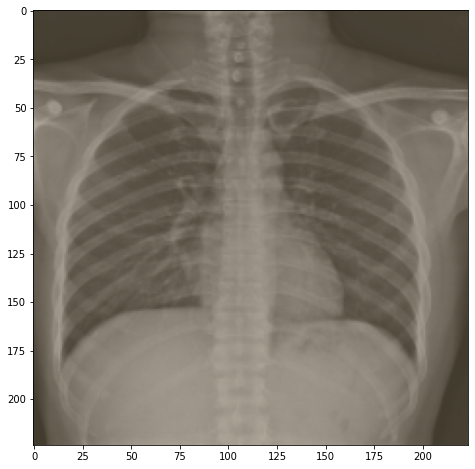

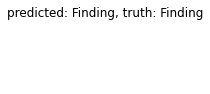

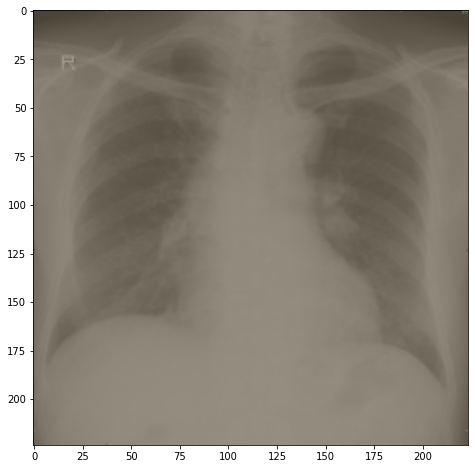

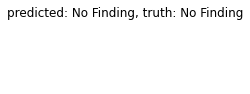

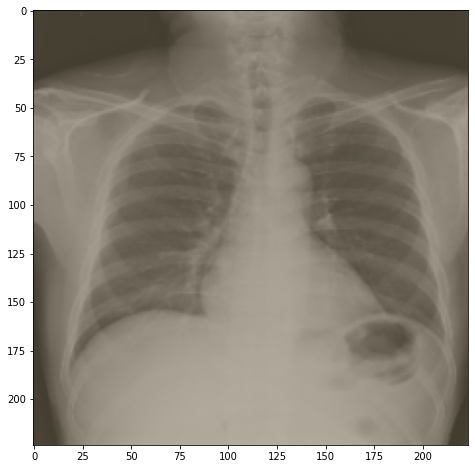

In [ ]:
# Apply function to visualise predictions
visualize_model(model_ft)

In [ ]:
# Function that displays a confusion matrix for a PyTorch trained model
# INPUT: model
# OUPUT: None
def display_confusion_matrix(model_ft):

    # Initialise lists
    y_pred = []
    y_true = []

    # Iterate over validation data
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_ft(inputs)

            # Recover prediction
            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            # Save Prediction
            y_pred.extend(output) 
            
            # Recover truth
            labels = labels.data.cpu().numpy()
            # Save truth
            y_true.extend(labels) 

    # Constant for classes
    classes = ('Finding', 'No Finding')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                        columns = [i for i in classes])
    # Display
    plt.figure(figsize = (12,7))
    sns.heatmap(df_cm, annot=True)

<Axes: >

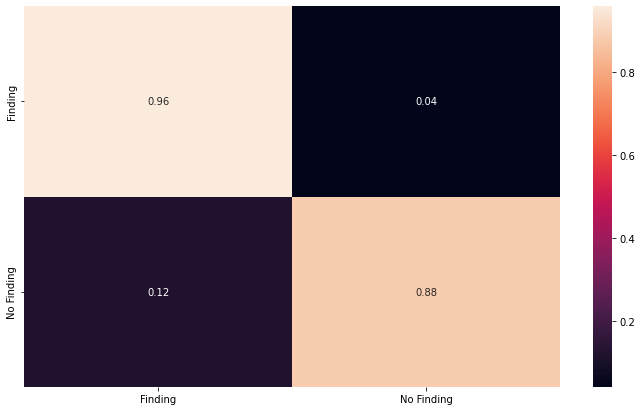

In [ ]:
# Apply function to display confusion matrix
display_confusion_matrix(model_ft)

In [ ]:
# Function that displays the roc curve for a PyTorch trained model
# INPUT: model
# OUPUT: None
def display_roc_curve(model_ft):

    # Initialise lists
    y_true = []
    y_score = []

    # Iterate over validation data
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Recover truth
            labels = labels.data.cpu().numpy()
            # Save truth
            y_true.extend(labels)

            # Recover scores
            scores = model_ft(inputs).softmax(0)
            
            # Save scores
            for i in range(len(scores)):
                y_score.append(torch.max(scores[i]).item())

    # Calculate false/positive and true/positive ratios
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = metrics.auc(fpr, tpr)

    # Calculate AUC score
    auc = metrics.roc_auc_score(y_true, y_score)

    # Create ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

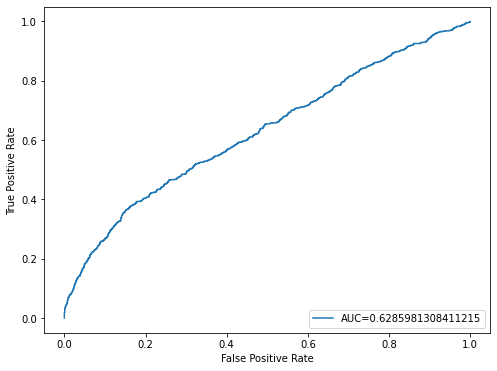

In [ ]:
# Apply function to display roc curve
display_roc_curve(model_ft)

## **Submission**

In [ ]:
# Function that tests the model on the 'submission' data and return a score with a class for each image
# INPUT: dataframe, dataloader, model trained, class dictionnary
# OUPUT: dataframe
def model_inference(submission_data, submission_loader, model_ft, class_names):

    # Initialise lists
    submission_scores = []
    submission_classes = []

    # Iterate over submission data
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(submission_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model_ft(inputs)

            # Recover Prediction
            output = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            # Save Prediction
            submission_classes.extend(output)

            # Recover scores
            scores = model_ft(inputs).softmax(0)
            
            # Save scores
            for i in range(len(scores)):
                submission_scores.append(torch.max(scores[i]).item())
    
    # Recover the class name
    submission_classes_name = []
    for cls in submission_classes:
        submission_classes_name.append(class_names[cls])

    # Update dataframe
    submission_data.drop(["image_path"], axis=1, inplace=True)
    submission_data["class_name"] = submission_classes_name
    submission_data["class_id"] = submission_classes
    submission_data["score"] = submission_scores
    
    return submission_data

In [ ]:
# Apply model inferences
submission_data = model_inference(submission_loader, model_ft, class_names)
submission_data

,image_id,class_name,class_id,score
0,002a34c58c5b758217ed1f584ccbcfe9,No Finding,0,0.088070
1,004f33259ee4aef671c2b95d54e4be68,No Finding,0,0.005598
2,008bdde2af2462e86fd373a445d0f4cd,No Finding,0,0.001754
3,009bc039326338823ca3aa84381f17f1,No Finding,0,0.016275
4,00a2145de1886cb9eb88869c85d74080,No Finding,0,0.007829
...,...,...,...,...
2995,ff91fb82429a27521bbec8569b041f02,No Finding,0,0.053834
2996,ff9fcc4087ed5e941209aa3fa948e364,No Finding,0,0.002410
2997,ffaa288c8abca300974f043b57d81521,No Finding,0,0.275810
2998,ffc441e0c8b7153844047483a577e7c3,Finding,1,0.997017


In [ ]:
# Save the ResNet18 predictions
submission_data.to_csv('/content/submission_2_cls_resnet18.csv',index = False)
submission_data.tail()

,image_id,class_name,class_id,score
2995,ff91fb82429a27521bbec8569b041f02,No Finding,0,0.053834
2996,ff9fcc4087ed5e941209aa3fa948e364,No Finding,0,0.002410
2997,ffaa288c8abca300974f043b57d81521,No Finding,0,0.275810
2998,ffc441e0c8b7153844047483a577e7c3,Finding,1,0.997017
2999,ffccf1709d0081d122a1d1f9edbefdf1,No Finding,0,0.605955


## **Save model**

In [ ]:
# Save the ResNet18 fine-tunned model
torch.save(model_ft.state_dict(), '/content/best_resnet18_pretrained_10.pt')